In [1]:
%run ../replay.ipynb

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import gym
import pybullet_envs
import random
import numpy as np
import tensorflow as tf
import time
from gym.envs.registration import register
from IPython.display import clear_output
from itertools import count

In [3]:
random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)
tf.keras.backend.set_floatx('float32')

In [4]:
env = gym.make('Humanoid-v2')
print('observation_space:', env.observation_space.shape)
print('action_space:', env.action_space.shape)
print('action lower:', env.action_space.low)
print('action upper:', env.action_space.high)

observation_space: (376,)
action_space: (17,)
action lower: [-0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4 -0.4
 -0.4 -0.4 -0.4]
action upper: [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]


In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda, concatenate

class Actor:
    def __init__(self, state_dim, action_dim, action_low, action_high):
        last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
        
        inputs = Input((state_dim,))
        hidden = Dense(256, activation='relu')(inputs)
        hidden = Dense(256, activation='relu')(hidden)
        outputs = Dense(action_dim, activation='tanh', kernel_initializer=last_init)(hidden)
        def rescale(x):
            return x * action_high
        outputs = Lambda(rescale)(outputs)
        
        self.model = Model(inputs, outputs)
        
        self.action_low = action_low
        self.action_high = action_high
        
        self.mu = 0.0
        self.sigma = 0.1
        
    def select(self, state, add_noise=True):
        states = np.expand_dims(state, axis=0)
        action = self.model(states)
        if add_noise:
            action += np.random.normal(self.mu, self.sigma, size=action.shape)
            
        action = np.clip(action, self.action_low, self.action_high)
        return action

In [6]:
class Critic:
    def __init__(self, state_dim, action_dim):
        state_in = Input((state_dim,))
        action_in = Input((action_dim,))
        concat = concatenate([state_in, action_in])
        hidden = Dense(256, activation='relu')(concat)
        hidden = Dense(256, activation='relu')(hidden)
        output = Dense(1, activation='linear')(hidden)
        
        self.model = Model([state_in, action_in], output)

In [10]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))
        
class Agent:
    def __init__(self, env):
        state_dim = np.squeeze(env.observation_space.shape)
        action_dim = np.squeeze(env.action_space.shape)
        
        self.state_dim, self.action_dim = state_dim, action_dim
        
        action_high = env.action_space.high
        action_low = env.action_space.low
        
        self.critic = Critic(state_dim, action_dim)
        self.actor = Actor(state_dim, action_dim, action_low, action_high)
        
        self.target_critic = Critic(state_dim, action_dim)
        self.update(self.target_critic, self.critic, 1)
        
        self.target_actor = Actor(state_dim, action_dim, action_low, action_high)
        self.update(self.target_actor, self.actor, 1)
        
        self.memory = Memory(1000000)
        self.batch_size = 256
        
        self.total_epochs = 0
        
        self.gamma = 0.99
        
        self.actor_optimizer = tf.keras.optimizers.Adam(lr=1e-3)
        self.critic_optimizer = tf.keras.optimizers.Adam(lr=1e-3)
        
        self.tau = 0.005
        
        self.start_timesteps = int(25e3)
        self.timesteps = 0
        
        self.env = env
        
    def update(self, target, src, tau=None):
        if tau == None:
            tau = self.tau
        if tau == 1:
            target.model.set_weights(src.model.get_weights())
        else:
            update_target(target.model.variables, src.model.variables, tau)
    
    @tf.function
    def update_actor(self, states):
        with tf.GradientTape() as tape:
            actions = self.actor.model(states)
            actor_loss = -tf.reduce_mean(self.critic.model([states, actions]))
            # minus sign to maximize critic value --> max(Q[i])
        actor_grad = tape.gradient(actor_loss, self.actor.model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.model.trainable_variables))

    @tf.function
    def train(self, states, actions, rewards, next_states, not_dones):
        states = tf.cast(states, dtype=tf.float32)
        actions = tf.cast(actions, dtype=tf.float32)
        rewards = tf.cast(rewards, dtype=tf.float32)
        next_states = tf.cast(next_states, dtype=tf.float32)
        not_dones = tf.cast(not_dones, dtype=tf.float32)
        
        next_action = self.target_actor.model(next_states)
        
        target_Q = self.target_critic.model([next_states, next_action])
        target_Q = rewards + self.gamma * target_Q * not_dones
        
        with tf.GradientTape() as tape:
            Q = self.critic.model([states, actions])
            loss = tf.reduce_mean(tf.square(target_Q - Q))
        grad = tape.gradient(loss, self.critic.model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grad, self.critic.model.trainable_variables))
        
        self.update_actor(states)
        
    def run(self, max_episode=100):
        history = []
        for ep in range(max_episode):
            state = env.reset()
            ep_reward = 0

            for step in count():
                if self.timesteps < self.start_timesteps:
                    action = self.env.action_space.sample()
                else:
                    action = self.actor.select(state)[0]
                self.timesteps += 1

                next_state, reward, done, _ = env.step(action)

                self.memory.add((state, action, reward, next_state, 1 - done))

                if len(self.memory.buffer) >= self.batch_size and self.timesteps > self.start_timesteps:
                    self.total_epochs += 1
                    samples = self.memory.replay(self.batch_size)

                    states, actions, rewards, next_states, not_dones = samples
                    self.train(states, actions, rewards, next_states, not_dones)
                    
                    self.update(self.target_critic, self.critic)
                    self.update(self.target_actor, self.actor)

                ep_reward += reward

                if done:
                    break
                state = next_state

            history.append(ep_reward)
            print('Episode: {}, ep_reward: {}, step: {}'.format(ep, ep_reward, step + 1))

        return history

In [11]:
agent = Agent(env)

In [12]:
history = agent.run(10000)

Episode: 0, ep_reward: 110.95761535376468, step: 22
Episode: 1, ep_reward: 151.5474651165871, step: 30
Episode: 2, ep_reward: 120.80365851214675, step: 24
Episode: 3, ep_reward: 96.17468832862819, step: 19
Episode: 4, ep_reward: 83.46015393068565, step: 17
Episode: 5, ep_reward: 120.24516134239758, step: 24
Episode: 6, ep_reward: 94.82245593318429, step: 19
Episode: 7, ep_reward: 101.20877290058395, step: 20
Episode: 8, ep_reward: 208.35980037779834, step: 41
Episode: 9, ep_reward: 99.4490085885823, step: 20
Episode: 10, ep_reward: 109.96317785967909, step: 22
Episode: 11, ep_reward: 120.27023508922694, step: 24
Episode: 12, ep_reward: 123.39168718482168, step: 24
Episode: 13, ep_reward: 96.36127232413699, step: 19
Episode: 14, ep_reward: 160.17908589904016, step: 31
Episode: 15, ep_reward: 83.44840331487069, step: 17
Episode: 16, ep_reward: 100.97140840724107, step: 20
Episode: 17, ep_reward: 89.48279784255284, step: 18
Episode: 18, ep_reward: 150.84778776546776, step: 32
Episode: 19,

Episode: 165, ep_reward: 151.04338634049395, step: 30
Episode: 166, ep_reward: 83.75312386291, step: 17
Episode: 167, ep_reward: 95.20466992226352, step: 19
Episode: 168, ep_reward: 83.46593471844024, step: 17
Episode: 169, ep_reward: 88.53023636585947, step: 18
Episode: 170, ep_reward: 160.68369148760505, step: 32
Episode: 171, ep_reward: 88.95272162243299, step: 18
Episode: 172, ep_reward: 117.08240730131394, step: 23
Episode: 173, ep_reward: 112.98692141069692, step: 22
Episode: 174, ep_reward: 95.88000074085917, step: 19
Episode: 175, ep_reward: 94.7733324592856, step: 19
Episode: 176, ep_reward: 133.28622779423978, step: 26
Episode: 177, ep_reward: 158.81800998499563, step: 31
Episode: 178, ep_reward: 140.0869548023173, step: 29
Episode: 179, ep_reward: 104.99781969377251, step: 21
Episode: 180, ep_reward: 205.9946189784782, step: 40
Episode: 181, ep_reward: 83.52969283183388, step: 17
Episode: 182, ep_reward: 132.69911074646748, step: 26
Episode: 183, ep_reward: 89.09950077595708

Episode: 324, ep_reward: 90.09467665190215, step: 18
Episode: 325, ep_reward: 132.97718387064364, step: 26
Episode: 326, ep_reward: 108.16980288900066, step: 21
Episode: 327, ep_reward: 152.2617366092493, step: 29
Episode: 328, ep_reward: 83.59485793889735, step: 17
Episode: 329, ep_reward: 148.95150737129228, step: 31
Episode: 330, ep_reward: 83.49279381598039, step: 17
Episode: 331, ep_reward: 88.3291839142548, step: 18
Episode: 332, ep_reward: 83.23016218047238, step: 17
Episode: 333, ep_reward: 83.3364937840672, step: 17
Episode: 334, ep_reward: 175.98576365058454, step: 36
Episode: 335, ep_reward: 96.53169343565028, step: 19
Episode: 336, ep_reward: 106.19546576905965, step: 21
Episode: 337, ep_reward: 94.6581139161337, step: 19
Episode: 338, ep_reward: 136.9951242245266, step: 27
Episode: 339, ep_reward: 88.4284968647275, step: 18
Episode: 340, ep_reward: 121.60600012080538, step: 24
Episode: 341, ep_reward: 95.08937210443389, step: 19
Episode: 342, ep_reward: 107.55632834972596,

Episode: 478, ep_reward: 107.00098947560545, step: 21
Episode: 479, ep_reward: 149.4211240721507, step: 31
Episode: 480, ep_reward: 101.78667937174275, step: 20
Episode: 481, ep_reward: 101.33307029723622, step: 20
Episode: 482, ep_reward: 88.61141885759761, step: 18
Episode: 483, ep_reward: 140.19089437621403, step: 27
Episode: 484, ep_reward: 135.88219598865123, step: 29
Episode: 485, ep_reward: 218.90517081399474, step: 42
Episode: 486, ep_reward: 154.30254046938285, step: 31
Episode: 487, ep_reward: 138.85629603609266, step: 27
Episode: 488, ep_reward: 94.47033460296466, step: 19
Episode: 489, ep_reward: 110.2619347459156, step: 22
Episode: 490, ep_reward: 150.5636928613623, step: 31
Episode: 491, ep_reward: 213.8400246918253, step: 44
Episode: 492, ep_reward: 94.14859936619462, step: 19
Episode: 493, ep_reward: 161.17428341371232, step: 31
Episode: 494, ep_reward: 153.8736916495672, step: 31
Episode: 495, ep_reward: 100.35740855903322, step: 20
Episode: 496, ep_reward: 110.3970000

Episode: 641, ep_reward: 159.85135931441874, step: 34
Episode: 642, ep_reward: 171.16887703872536, step: 36
Episode: 643, ep_reward: 89.2328777653866, step: 18
Episode: 644, ep_reward: 89.15268502928434, step: 18
Episode: 645, ep_reward: 78.42522086384561, step: 16
Episode: 646, ep_reward: 104.82700353145799, step: 21
Episode: 647, ep_reward: 106.95080628522184, step: 21
Episode: 648, ep_reward: 83.41960611886633, step: 17
Episode: 649, ep_reward: 90.27894023064616, step: 18
Episode: 650, ep_reward: 212.1420615577138, step: 42
Episode: 651, ep_reward: 88.22571099704443, step: 18
Episode: 652, ep_reward: 83.32162122173973, step: 17
Episode: 653, ep_reward: 89.11666543913861, step: 18
Episode: 654, ep_reward: 139.3669255327641, step: 27
Episode: 655, ep_reward: 187.31260481636767, step: 37
Episode: 656, ep_reward: 98.9979674895129, step: 20
Episode: 657, ep_reward: 102.06273293224928, step: 20
Episode: 658, ep_reward: 217.42558439278707, step: 44
Episode: 659, ep_reward: 89.3307397079994

Episode: 799, ep_reward: 104.37726984962498, step: 21
Episode: 800, ep_reward: 90.4932691641284, step: 18
Episode: 801, ep_reward: 154.09542311986496, step: 30
Episode: 802, ep_reward: 101.95525246105355, step: 20
Episode: 803, ep_reward: 89.73901505185174, step: 18
Episode: 804, ep_reward: 122.39465711079355, step: 25
Episode: 805, ep_reward: 113.14134215563877, step: 22
Episode: 806, ep_reward: 120.19116235099999, step: 24
Episode: 807, ep_reward: 140.60511667467026, step: 28
Episode: 808, ep_reward: 89.17142261593285, step: 18
Episode: 809, ep_reward: 172.5636311788986, step: 36
Episode: 810, ep_reward: 115.9988045984168, step: 23
Episode: 811, ep_reward: 122.94220657260851, step: 24
Episode: 812, ep_reward: 118.34949803581155, step: 24
Episode: 813, ep_reward: 106.7373876185365, step: 21
Episode: 814, ep_reward: 154.11584254529848, step: 30
Episode: 815, ep_reward: 99.45066364409485, step: 20
Episode: 816, ep_reward: 247.13728333215334, step: 48
Episode: 817, ep_reward: 127.6923195

Episode: 951, ep_reward: 83.18447266356571, step: 17
Episode: 952, ep_reward: 177.974640556398, step: 38
Episode: 953, ep_reward: 83.59018278474562, step: 17
Episode: 954, ep_reward: 100.43264989033331, step: 20
Episode: 955, ep_reward: 89.68529905387312, step: 18
Episode: 956, ep_reward: 157.47971558497414, step: 30
Episode: 957, ep_reward: 158.2693455131638, step: 31
Episode: 958, ep_reward: 89.13561772228721, step: 18
Episode: 959, ep_reward: 113.87888711369642, step: 24
Episode: 960, ep_reward: 101.45553309290695, step: 20
Episode: 961, ep_reward: 88.53050435303551, step: 18
Episode: 962, ep_reward: 101.68596410964263, step: 20
Episode: 963, ep_reward: 146.61116735340323, step: 28
Episode: 964, ep_reward: 187.72665423238874, step: 37
Episode: 965, ep_reward: 124.23045717856108, step: 24
Episode: 966, ep_reward: 114.63366814244363, step: 22
Episode: 967, ep_reward: 83.40372035984642, step: 17
Episode: 968, ep_reward: 193.85328080674648, step: 38
Episode: 969, ep_reward: 94.904508406

Episode: 1091, ep_reward: 66.94023902776914, step: 14
Episode: 1092, ep_reward: 66.65824483696424, step: 14
Episode: 1093, ep_reward: 66.80533236579919, step: 14
Episode: 1094, ep_reward: 62.29074093870285, step: 13
Episode: 1095, ep_reward: 66.9007768498485, step: 14
Episode: 1096, ep_reward: 66.85319773672171, step: 14
Episode: 1097, ep_reward: 66.94634071300956, step: 14
Episode: 1098, ep_reward: 66.68257681342865, step: 14
Episode: 1099, ep_reward: 66.92638292021054, step: 14
Episode: 1100, ep_reward: 66.78965713413187, step: 14
Episode: 1101, ep_reward: 66.8815083300497, step: 14
Episode: 1102, ep_reward: 67.10882253800055, step: 14
Episode: 1103, ep_reward: 66.7630086808223, step: 14
Episode: 1104, ep_reward: 66.87841906190809, step: 14
Episode: 1105, ep_reward: 66.79754176928435, step: 14
Episode: 1106, ep_reward: 66.7638889693818, step: 14
Episode: 1107, ep_reward: 67.11083198666968, step: 14
Episode: 1108, ep_reward: 66.85447058034644, step: 14
Episode: 1109, ep_reward: 67.144

Episode: 1242, ep_reward: 212.54281557944503, step: 43
Episode: 1243, ep_reward: 208.70771676545684, step: 42
Episode: 1244, ep_reward: 198.72547793390208, step: 40
Episode: 1245, ep_reward: 206.23782438592062, step: 41
Episode: 1246, ep_reward: 205.17079667613822, step: 41
Episode: 1247, ep_reward: 194.1623865835485, step: 39
Episode: 1248, ep_reward: 209.65167420065532, step: 42
Episode: 1249, ep_reward: 215.00359219730203, step: 43
Episode: 1250, ep_reward: 214.43451688610733, step: 43
Episode: 1251, ep_reward: 196.77952367684136, step: 40
Episode: 1252, ep_reward: 212.4843347965143, step: 42
Episode: 1253, ep_reward: 191.2068880688618, step: 38
Episode: 1254, ep_reward: 180.28237899183017, step: 36
Episode: 1255, ep_reward: 198.37765196938892, step: 40
Episode: 1256, ep_reward: 177.9695437800253, step: 36
Episode: 1257, ep_reward: 201.148250428625, step: 40
Episode: 1258, ep_reward: 204.954262948741, step: 41
Episode: 1259, ep_reward: 199.25323373506262, step: 40
Episode: 1260, ep_

Episode: 1392, ep_reward: 173.21635337817403, step: 36
Episode: 1393, ep_reward: 164.7591969284584, step: 34
Episode: 1394, ep_reward: 173.95347820432625, step: 36
Episode: 1395, ep_reward: 169.77075794598292, step: 35
Episode: 1396, ep_reward: 178.5794077962443, step: 37
Episode: 1397, ep_reward: 172.1650464894346, step: 36
Episode: 1398, ep_reward: 168.71853773499205, step: 35
Episode: 1399, ep_reward: 174.94885470790894, step: 36
Episode: 1400, ep_reward: 172.0169649007983, step: 35
Episode: 1401, ep_reward: 176.87440553437477, step: 36
Episode: 1402, ep_reward: 173.35367061087075, step: 36
Episode: 1403, ep_reward: 167.6649726318462, step: 35
Episode: 1404, ep_reward: 164.30101866114296, step: 34
Episode: 1405, ep_reward: 171.01032994947303, step: 35
Episode: 1406, ep_reward: 170.628795120562, step: 35
Episode: 1407, ep_reward: 180.9635719923382, step: 37
Episode: 1408, ep_reward: 164.6105641520349, step: 34
Episode: 1409, ep_reward: 173.6825269238596, step: 36
Episode: 1410, ep_re

Episode: 1543, ep_reward: 275.16434421452, step: 60
Episode: 1544, ep_reward: 434.98362122917956, step: 84
Episode: 1545, ep_reward: 321.7406658142125, step: 71
Episode: 1546, ep_reward: 295.44289501398464, step: 68
Episode: 1547, ep_reward: 256.6141461889952, step: 62
Episode: 1548, ep_reward: 326.25543158900183, step: 75
Episode: 1549, ep_reward: 322.15303635848545, step: 72
Episode: 1550, ep_reward: 274.9574778234071, step: 63
Episode: 1551, ep_reward: 207.53150658247142, step: 50
Episode: 1552, ep_reward: 294.90012040348944, step: 66
Episode: 1553, ep_reward: 324.50266424454054, step: 77
Episode: 1554, ep_reward: 288.1335777497383, step: 67
Episode: 1555, ep_reward: 331.2505387318378, step: 78
Episode: 1556, ep_reward: 329.2674679716975, step: 70
Episode: 1557, ep_reward: 327.00103068662804, step: 77
Episode: 1558, ep_reward: 328.3977655206365, step: 76
Episode: 1559, ep_reward: 233.2933338083404, step: 57
Episode: 1560, ep_reward: 240.99991788743625, step: 56
Episode: 1561, ep_rew

Episode: 1694, ep_reward: 331.56359004393425, step: 67
Episode: 1695, ep_reward: 337.5516855500544, step: 68
Episode: 1696, ep_reward: 168.96975323952125, step: 36
Episode: 1697, ep_reward: 240.5220479889668, step: 48
Episode: 1698, ep_reward: 374.99956924204525, step: 69
Episode: 1699, ep_reward: 172.1887680741869, step: 36
Episode: 1700, ep_reward: 380.67653667044175, step: 73
Episode: 1701, ep_reward: 273.7971018157546, step: 50
Episode: 1702, ep_reward: 285.71213338413526, step: 57
Episode: 1703, ep_reward: 362.8746611332292, step: 67
Episode: 1704, ep_reward: 399.5693860853261, step: 76
Episode: 1705, ep_reward: 265.566296274389, step: 48
Episode: 1706, ep_reward: 327.0273348657575, step: 60
Episode: 1707, ep_reward: 378.2953573741809, step: 71
Episode: 1708, ep_reward: 475.9489154225258, step: 96
Episode: 1709, ep_reward: 315.20787642376854, step: 61
Episode: 1710, ep_reward: 305.8792345837735, step: 60
Episode: 1711, ep_reward: 243.68737886971024, step: 46
Episode: 1712, ep_rewa

Episode: 1845, ep_reward: 485.8225981233219, step: 97
Episode: 1846, ep_reward: 292.4354644556392, step: 58
Episode: 1847, ep_reward: 419.54313158064105, step: 90
Episode: 1848, ep_reward: 364.3717222242635, step: 79
Episode: 1849, ep_reward: 306.93096415521535, step: 70
Episode: 1850, ep_reward: 265.1473668433182, step: 55
Episode: 1851, ep_reward: 298.9743976981564, step: 61
Episode: 1852, ep_reward: 301.68712955182156, step: 68
Episode: 1853, ep_reward: 336.48599441663794, step: 76
Episode: 1854, ep_reward: 293.14569433927466, step: 66
Episode: 1855, ep_reward: 398.82005955547197, step: 84
Episode: 1856, ep_reward: 231.6190088836567, step: 45
Episode: 1857, ep_reward: 359.9803201723108, step: 77
Episode: 1858, ep_reward: 526.7842674997424, step: 101
Episode: 1859, ep_reward: 243.06164432631329, step: 49
Episode: 1860, ep_reward: 246.23620493175554, step: 48
Episode: 1861, ep_reward: 279.05151933109266, step: 64
Episode: 1862, ep_reward: 308.71261602652163, step: 62
Episode: 1863, ep

Episode: 1996, ep_reward: 552.0506303648574, step: 110
Episode: 1997, ep_reward: 542.9015721460955, step: 110
Episode: 1998, ep_reward: 496.20098213587556, step: 101
Episode: 1999, ep_reward: 439.1361674353003, step: 84
Episode: 2000, ep_reward: 374.71624379055106, step: 79
Episode: 2001, ep_reward: 440.1279470285508, step: 82
Episode: 2002, ep_reward: 355.83196809611167, step: 70
Episode: 2003, ep_reward: 357.31508216160006, step: 80
Episode: 2004, ep_reward: 330.43501789809574, step: 74
Episode: 2005, ep_reward: 353.5810957257728, step: 82
Episode: 2006, ep_reward: 306.83320015145966, step: 58
Episode: 2007, ep_reward: 405.84945228741924, step: 76
Episode: 2008, ep_reward: 387.2156177833795, step: 75
Episode: 2009, ep_reward: 568.4118463002267, step: 104
Episode: 2010, ep_reward: 431.93669980003364, step: 87
Episode: 2011, ep_reward: 449.4745033268613, step: 94
Episode: 2012, ep_reward: 293.27943459789344, step: 59
Episode: 2013, ep_reward: 267.31586800656936, step: 61
Episode: 2014,

Episode: 2147, ep_reward: 479.0111398504002, step: 100
Episode: 2148, ep_reward: 360.39374643811334, step: 68
Episode: 2149, ep_reward: 264.9446411340558, step: 50
Episode: 2150, ep_reward: 395.56534415548526, step: 78
Episode: 2151, ep_reward: 298.3508258019715, step: 58
Episode: 2152, ep_reward: 428.620914121662, step: 88
Episode: 2153, ep_reward: 474.34295883420987, step: 106
Episode: 2154, ep_reward: 490.43412301509164, step: 107
Episode: 2155, ep_reward: 658.4373461048652, step: 138
Episode: 2156, ep_reward: 357.8623926066378, step: 70
Episode: 2157, ep_reward: 476.26399888405155, step: 98
Episode: 2158, ep_reward: 499.44625118298075, step: 95
Episode: 2159, ep_reward: 338.5682161504693, step: 68
Episode: 2160, ep_reward: 366.14113241495477, step: 78
Episode: 2161, ep_reward: 322.3045509533831, step: 61
Episode: 2162, ep_reward: 405.21356156217416, step: 83
Episode: 2163, ep_reward: 388.50581256573906, step: 85
Episode: 2164, ep_reward: 358.13992515910155, step: 79
Episode: 2165, 

Episode: 2298, ep_reward: 327.1388159663836, step: 63
Episode: 2299, ep_reward: 493.41342662118, step: 95
Episode: 2300, ep_reward: 443.51904287800085, step: 90
Episode: 2301, ep_reward: 343.7484900497323, step: 73
Episode: 2302, ep_reward: 105.77470260241577, step: 22
Episode: 2303, ep_reward: 347.7127802374444, step: 75
Episode: 2304, ep_reward: 404.9982653669877, step: 77
Episode: 2305, ep_reward: 407.5842734795355, step: 84
Episode: 2306, ep_reward: 413.96787058954567, step: 85
Episode: 2307, ep_reward: 421.9907779634093, step: 82
Episode: 2308, ep_reward: 386.8964233717931, step: 81
Episode: 2309, ep_reward: 354.6022283706999, step: 77
Episode: 2310, ep_reward: 424.9964582252843, step: 88
Episode: 2311, ep_reward: 440.80625929024563, step: 88
Episode: 2312, ep_reward: 416.0862962327301, step: 86
Episode: 2313, ep_reward: 339.18244851643453, step: 71
Episode: 2314, ep_reward: 358.58270503156024, step: 75
Episode: 2315, ep_reward: 532.0854837122373, step: 111
Episode: 2316, ep_rewar

Episode: 2449, ep_reward: 424.08146355124575, step: 88
Episode: 2450, ep_reward: 330.6246373714628, step: 65
Episode: 2451, ep_reward: 266.6258874698787, step: 54
Episode: 2452, ep_reward: 274.9890999913433, step: 55
Episode: 2453, ep_reward: 282.4624476108125, step: 57
Episode: 2454, ep_reward: 266.876783638115, step: 52
Episode: 2455, ep_reward: 586.1041456645006, step: 133
Episode: 2456, ep_reward: 225.00832671518899, step: 47
Episode: 2457, ep_reward: 470.2256283951601, step: 89
Episode: 2458, ep_reward: 409.572244808325, step: 79
Episode: 2459, ep_reward: 396.8917481414489, step: 76
Episode: 2460, ep_reward: 344.1713820529976, step: 68
Episode: 2461, ep_reward: 203.85062881570394, step: 42
Episode: 2462, ep_reward: 306.2990270794623, step: 62
Episode: 2463, ep_reward: 365.25788189391164, step: 70
Episode: 2464, ep_reward: 254.17119552422747, step: 51
Episode: 2465, ep_reward: 284.7988326801726, step: 57
Episode: 2466, ep_reward: 212.2935838737149, step: 42
Episode: 2467, ep_reward

Episode: 2600, ep_reward: 435.5678013506577, step: 86
Episode: 2601, ep_reward: 363.86282550401, step: 75
Episode: 2602, ep_reward: 469.45253673670646, step: 92
Episode: 2603, ep_reward: 480.03262557859426, step: 92
Episode: 2604, ep_reward: 370.5736039489693, step: 75
Episode: 2605, ep_reward: 416.5007297417489, step: 82
Episode: 2606, ep_reward: 347.2143330676028, step: 66
Episode: 2607, ep_reward: 450.63908573463374, step: 88
Episode: 2608, ep_reward: 341.74048913467055, step: 65
Episode: 2609, ep_reward: 455.89523620439195, step: 91
Episode: 2610, ep_reward: 377.34641301463284, step: 70
Episode: 2611, ep_reward: 287.37118441602706, step: 59
Episode: 2612, ep_reward: 386.33585644326513, step: 86
Episode: 2613, ep_reward: 310.70257924087883, step: 66
Episode: 2614, ep_reward: 337.8098106667855, step: 66
Episode: 2615, ep_reward: 338.7475684995976, step: 77
Episode: 2616, ep_reward: 206.91029065930647, step: 51
Episode: 2617, ep_reward: 347.9201874552591, step: 75
Episode: 2618, ep_re

Episode: 2751, ep_reward: 850.1766690379293, step: 171
Episode: 2752, ep_reward: 514.4999709842641, step: 116
Episode: 2753, ep_reward: 225.22725179864165, step: 49
Episode: 2754, ep_reward: 325.7472091221603, step: 77
Episode: 2755, ep_reward: 288.13546392875503, step: 67
Episode: 2756, ep_reward: 341.3368215832014, step: 77
Episode: 2757, ep_reward: 335.7645837489902, step: 79
Episode: 2758, ep_reward: 491.82176161247963, step: 109
Episode: 2759, ep_reward: 312.94082364939453, step: 71
Episode: 2760, ep_reward: 317.86596233708593, step: 71
Episode: 2761, ep_reward: 391.5563708239456, step: 95
Episode: 2762, ep_reward: 357.211769747206, step: 83
Episode: 2763, ep_reward: 258.8848156197807, step: 60
Episode: 2764, ep_reward: 423.26561170099944, step: 86
Episode: 2765, ep_reward: 435.69375553392064, step: 99
Episode: 2766, ep_reward: 537.1873431629032, step: 108
Episode: 2767, ep_reward: 206.44904364851558, step: 45
Episode: 2768, ep_reward: 295.8636000945917, step: 74
Episode: 2769, ep

Episode: 2902, ep_reward: 440.4763781706402, step: 96
Episode: 2903, ep_reward: 500.8552604855401, step: 105
Episode: 2904, ep_reward: 990.5563154072084, step: 202
Episode: 2905, ep_reward: 339.8023315066151, step: 74
Episode: 2906, ep_reward: 593.0921831056793, step: 119
Episode: 2907, ep_reward: 544.6228845608072, step: 109
Episode: 2908, ep_reward: 450.1063592554302, step: 87
Episode: 2909, ep_reward: 542.4270549482683, step: 110
Episode: 2910, ep_reward: 448.32160600879826, step: 91
Episode: 2911, ep_reward: 410.14207624838116, step: 82
Episode: 2912, ep_reward: 476.9451964796396, step: 103
Episode: 2913, ep_reward: 307.80187393765607, step: 67
Episode: 2914, ep_reward: 494.17201073771815, step: 99
Episode: 2915, ep_reward: 273.5806325563981, step: 61
Episode: 2916, ep_reward: 480.27771160513356, step: 97
Episode: 2917, ep_reward: 341.177389514499, step: 76
Episode: 2918, ep_reward: 279.9508938052431, step: 57
Episode: 2919, ep_reward: 419.55348568086885, step: 86
Episode: 2920, ep

Episode: 3053, ep_reward: 515.8803267555282, step: 115
Episode: 3054, ep_reward: 344.45092094038836, step: 80
Episode: 3055, ep_reward: 543.6755143599016, step: 122
Episode: 3056, ep_reward: 298.6595153338836, step: 67
Episode: 3057, ep_reward: 396.6214622639051, step: 85
Episode: 3058, ep_reward: 288.98889615219764, step: 68
Episode: 3059, ep_reward: 663.7475771300452, step: 140
Episode: 3060, ep_reward: 810.5211243245893, step: 175
Episode: 3061, ep_reward: 315.56039048959076, step: 68
Episode: 3062, ep_reward: 304.0023661134606, step: 61
Episode: 3063, ep_reward: 159.3265827305734, step: 31
Episode: 3064, ep_reward: 384.44061367580883, step: 91
Episode: 3065, ep_reward: 335.66233845579353, step: 79
Episode: 3066, ep_reward: 478.8091686823544, step: 105
Episode: 3067, ep_reward: 731.6393475874949, step: 160
Episode: 3068, ep_reward: 408.97354815892766, step: 95
Episode: 3069, ep_reward: 504.3195742023405, step: 118
Episode: 3070, ep_reward: 366.4734631782176, step: 78
Episode: 3071, 

Episode: 3204, ep_reward: 355.511424033664, step: 70
Episode: 3205, ep_reward: 404.056149984578, step: 83
Episode: 3206, ep_reward: 547.1787853321315, step: 120
Episode: 3207, ep_reward: 380.5184490228587, step: 76
Episode: 3208, ep_reward: 484.92136053048625, step: 110
Episode: 3209, ep_reward: 464.9506991400814, step: 88
Episode: 3210, ep_reward: 336.584470941274, step: 74
Episode: 3211, ep_reward: 681.9782960467531, step: 132
Episode: 3212, ep_reward: 308.32414058104825, step: 62
Episode: 3213, ep_reward: 601.1105661467285, step: 123
Episode: 3214, ep_reward: 506.5049615688066, step: 111
Episode: 3215, ep_reward: 791.1213468382426, step: 163
Episode: 3216, ep_reward: 461.6978525191222, step: 101
Episode: 3217, ep_reward: 604.1561913645278, step: 119
Episode: 3218, ep_reward: 402.1981831834911, step: 74
Episode: 3219, ep_reward: 552.1381357619199, step: 123
Episode: 3220, ep_reward: 549.4738218234165, step: 121
Episode: 3221, ep_reward: 398.16497502075856, step: 77
Episode: 3222, ep_

Episode: 3355, ep_reward: 316.99692143819783, step: 66
Episode: 3356, ep_reward: 474.1975388004681, step: 93
Episode: 3357, ep_reward: 462.6997784860046, step: 98
Episode: 3358, ep_reward: 327.6751997688875, step: 73
Episode: 3359, ep_reward: 549.0208719056983, step: 102
Episode: 3360, ep_reward: 521.9195509382525, step: 104
Episode: 3361, ep_reward: 340.85819198285503, step: 74
Episode: 3362, ep_reward: 559.9857340321755, step: 109
Episode: 3363, ep_reward: 322.1824230550937, step: 60
Episode: 3364, ep_reward: 333.64723390014365, step: 61
Episode: 3365, ep_reward: 403.4292916794215, step: 76
Episode: 3366, ep_reward: 617.9358258127186, step: 119
Episode: 3367, ep_reward: 501.15856945304273, step: 93
Episode: 3368, ep_reward: 258.34617303618757, step: 49
Episode: 3369, ep_reward: 550.7355523533116, step: 118
Episode: 3370, ep_reward: 321.55380972687226, step: 60
Episode: 3371, ep_reward: 542.2059282163966, step: 107
Episode: 3372, ep_reward: 199.95955965269818, step: 39
Episode: 3373, 

Episode: 3506, ep_reward: 554.5848385631944, step: 120
Episode: 3507, ep_reward: 386.7459591759449, step: 84
Episode: 3508, ep_reward: 392.9396706538833, step: 79
Episode: 3509, ep_reward: 378.5060197972133, step: 71
Episode: 3510, ep_reward: 361.96265111716457, step: 77
Episode: 3511, ep_reward: 432.2683464932233, step: 87
Episode: 3512, ep_reward: 449.4251200757956, step: 100
Episode: 3513, ep_reward: 404.10338952478986, step: 82
Episode: 3514, ep_reward: 464.38147557963157, step: 95
Episode: 3515, ep_reward: 443.9591122530031, step: 96
Episode: 3516, ep_reward: 284.8504940071223, step: 59
Episode: 3517, ep_reward: 425.7642332477971, step: 92
Episode: 3518, ep_reward: 445.8879661963214, step: 96
Episode: 3519, ep_reward: 333.6339709495539, step: 69
Episode: 3520, ep_reward: 348.8233653600929, step: 73
Episode: 3521, ep_reward: 330.2827107219639, step: 62
Episode: 3522, ep_reward: 289.61331836441406, step: 61
Episode: 3523, ep_reward: 433.27771962784, step: 98
Episode: 3524, ep_reward

Episode: 3657, ep_reward: 341.4166734009403, step: 68
Episode: 3658, ep_reward: 137.37191667238798, step: 27
Episode: 3659, ep_reward: 506.49008691058043, step: 104
Episode: 3660, ep_reward: 118.99322085717635, step: 24
Episode: 3661, ep_reward: 155.90868627868073, step: 34
Episode: 3662, ep_reward: 294.2990003470708, step: 62
Episode: 3663, ep_reward: 134.7378317177692, step: 28
Episode: 3664, ep_reward: 363.35778640762993, step: 81
Episode: 3665, ep_reward: 365.7811041743587, step: 74
Episode: 3666, ep_reward: 309.5984015755855, step: 68
Episode: 3667, ep_reward: 364.45286930042806, step: 80
Episode: 3668, ep_reward: 129.23790389985524, step: 26
Episode: 3669, ep_reward: 177.84842250851358, step: 34
Episode: 3670, ep_reward: 317.03918654947955, step: 72
Episode: 3671, ep_reward: 173.52542049707986, step: 34
Episode: 3672, ep_reward: 137.69433583525424, step: 27
Episode: 3673, ep_reward: 443.6866850250654, step: 87
Episode: 3674, ep_reward: 383.1813780044324, step: 72
Episode: 3675, e

Episode: 3807, ep_reward: 377.0646145312228, step: 82
Episode: 3808, ep_reward: 304.7805065216624, step: 64
Episode: 3809, ep_reward: 432.782083149182, step: 83
Episode: 3810, ep_reward: 699.6620959320019, step: 143
Episode: 3811, ep_reward: 527.3997535699395, step: 104
Episode: 3812, ep_reward: 370.59952380486817, step: 85
Episode: 3813, ep_reward: 438.00359522491624, step: 99
Episode: 3814, ep_reward: 815.9996235529999, step: 161
Episode: 3815, ep_reward: 375.6057708319941, step: 72
Episode: 3816, ep_reward: 329.49319096203664, step: 68
Episode: 3817, ep_reward: 424.97777800091745, step: 82
Episode: 3818, ep_reward: 293.9028503247318, step: 67
Episode: 3819, ep_reward: 407.5228461092223, step: 78
Episode: 3820, ep_reward: 504.27234014452273, step: 101
Episode: 3821, ep_reward: 389.4052451581786, step: 75
Episode: 3822, ep_reward: 358.8428246366995, step: 71
Episode: 3823, ep_reward: 342.15825950922505, step: 79
Episode: 3824, ep_reward: 278.3757793153975, step: 61
Episode: 3825, ep_r

Episode: 3958, ep_reward: 392.02045734915066, step: 84
Episode: 3959, ep_reward: 262.4353785522744, step: 53
Episode: 3960, ep_reward: 415.979683039677, step: 91
Episode: 3961, ep_reward: 293.7702958440162, step: 56
Episode: 3962, ep_reward: 788.3377757986262, step: 168
Episode: 3963, ep_reward: 544.5825948122016, step: 114
Episode: 3964, ep_reward: 364.5836562222604, step: 81
Episode: 3965, ep_reward: 392.60690109271195, step: 91
Episode: 3966, ep_reward: 338.7731390085296, step: 71
Episode: 3967, ep_reward: 376.72989908046503, step: 82
Episode: 3968, ep_reward: 442.5794464669928, step: 97
Episode: 3969, ep_reward: 467.6504443433301, step: 101
Episode: 3970, ep_reward: 355.3886756481367, step: 73
Episode: 3971, ep_reward: 349.2313354722797, step: 78
Episode: 3972, ep_reward: 256.9842500348574, step: 56
Episode: 3973, ep_reward: 255.1385781003392, step: 53
Episode: 3974, ep_reward: 401.0149990010101, step: 84
Episode: 3975, ep_reward: 345.9726649533904, step: 77
Episode: 3976, ep_rewar

Episode: 4109, ep_reward: 275.91493395778724, step: 58
Episode: 4110, ep_reward: 320.0440728512701, step: 67
Episode: 4111, ep_reward: 604.5263312215044, step: 117
Episode: 4112, ep_reward: 293.89462729946223, step: 61
Episode: 4113, ep_reward: 370.4568484668806, step: 81
Episode: 4114, ep_reward: 497.1812690797309, step: 100
Episode: 4115, ep_reward: 263.13584457736215, step: 53
Episode: 4116, ep_reward: 381.4350404369203, step: 79
Episode: 4117, ep_reward: 186.54380865190183, step: 39
Episode: 4118, ep_reward: 127.0447708105994, step: 26
Episode: 4119, ep_reward: 393.35818188086233, step: 79
Episode: 4120, ep_reward: 456.9999556297628, step: 92
Episode: 4121, ep_reward: 398.9878978502644, step: 89
Episode: 4122, ep_reward: 299.6836332162331, step: 62
Episode: 4123, ep_reward: 203.73458526558915, step: 42
Episode: 4124, ep_reward: 358.34932652018836, step: 72
Episode: 4125, ep_reward: 347.8637286233795, step: 69
Episode: 4126, ep_reward: 439.3121401592147, step: 95
Episode: 4127, ep_r

Episode: 4260, ep_reward: 571.0201616487683, step: 122
Episode: 4261, ep_reward: 642.5738840963967, step: 130
Episode: 4262, ep_reward: 476.9315148872853, step: 99
Episode: 4263, ep_reward: 403.67142049527104, step: 92
Episode: 4264, ep_reward: 811.8270502493982, step: 167
Episode: 4265, ep_reward: 500.0181065047117, step: 101
Episode: 4266, ep_reward: 559.1455902480803, step: 113
Episode: 4267, ep_reward: 297.0968654886928, step: 64
Episode: 4268, ep_reward: 413.685929583015, step: 88
Episode: 4269, ep_reward: 570.2174849324853, step: 114
Episode: 4270, ep_reward: 369.5363216695893, step: 83
Episode: 4271, ep_reward: 544.324671159003, step: 99
Episode: 4272, ep_reward: 336.97784291125606, step: 70
Episode: 4273, ep_reward: 417.90104493091826, step: 92
Episode: 4274, ep_reward: 650.8299017757438, step: 131
Episode: 4275, ep_reward: 398.6213088270036, step: 81
Episode: 4276, ep_reward: 288.53441650380125, step: 60
Episode: 4277, ep_reward: 419.83386698922527, step: 84
Episode: 4278, ep_

Episode: 4410, ep_reward: 259.2297658958282, step: 60
Episode: 4411, ep_reward: 248.79068791611215, step: 55
Episode: 4412, ep_reward: 245.99390150487758, step: 55
Episode: 4413, ep_reward: 214.32864201493715, step: 48
Episode: 4414, ep_reward: 338.8105253162299, step: 75
Episode: 4415, ep_reward: 170.75421013897295, step: 38
Episode: 4416, ep_reward: 241.12766536461214, step: 52
Episode: 4417, ep_reward: 226.77547998831514, step: 44
Episode: 4418, ep_reward: 189.14857522630584, step: 42
Episode: 4419, ep_reward: 212.22051552144143, step: 46
Episode: 4420, ep_reward: 291.77715478229106, step: 62
Episode: 4421, ep_reward: 209.34898765336249, step: 48
Episode: 4422, ep_reward: 214.79877040793914, step: 49
Episode: 4423, ep_reward: 328.30917344643115, step: 68
Episode: 4424, ep_reward: 215.60929068119805, step: 43
Episode: 4425, ep_reward: 526.5986139295877, step: 108
Episode: 4426, ep_reward: 228.8898918236578, step: 45
Episode: 4427, ep_reward: 341.7928789370857, step: 73
Episode: 4428,

Episode: 4560, ep_reward: 1594.202985368712, step: 347
Episode: 4561, ep_reward: 503.34492286407453, step: 110
Episode: 4562, ep_reward: 648.2655247769087, step: 143
Episode: 4563, ep_reward: 840.5746418341313, step: 168
Episode: 4564, ep_reward: 1256.4246587697305, step: 258
Episode: 4565, ep_reward: 828.7776507743233, step: 182
Episode: 4566, ep_reward: 538.3951356322314, step: 112
Episode: 4567, ep_reward: 1121.6609950726383, step: 238
Episode: 4568, ep_reward: 1174.2914326997543, step: 249
Episode: 4569, ep_reward: 1030.9235870812072, step: 231
Episode: 4570, ep_reward: 432.56795806728576, step: 95
Episode: 4571, ep_reward: 486.30214028726414, step: 109
Episode: 4572, ep_reward: 472.51286663757446, step: 108
Episode: 4573, ep_reward: 558.2478236329844, step: 120
Episode: 4574, ep_reward: 483.08194520085436, step: 101
Episode: 4575, ep_reward: 570.9333877174817, step: 119
Episode: 4576, ep_reward: 884.2239451931778, step: 173
Episode: 4577, ep_reward: 475.37336024652654, step: 96
Ep

Episode: 4710, ep_reward: 302.43448138326784, step: 60
Episode: 4711, ep_reward: 324.2419897817574, step: 61
Episode: 4712, ep_reward: 357.2289838356627, step: 69
Episode: 4713, ep_reward: 342.13382726620375, step: 67
Episode: 4714, ep_reward: 306.4543772349428, step: 58
Episode: 4715, ep_reward: 376.1084986506021, step: 70
Episode: 4716, ep_reward: 262.33752316297125, step: 52
Episode: 4717, ep_reward: 260.6306396132841, step: 52
Episode: 4718, ep_reward: 306.6390385604302, step: 59
Episode: 4719, ep_reward: 298.8572358879081, step: 57
Episode: 4720, ep_reward: 258.749525515519, step: 50
Episode: 4721, ep_reward: 281.5746210036743, step: 53
Episode: 4722, ep_reward: 323.9188162956809, step: 64
Episode: 4723, ep_reward: 293.26167814156526, step: 57
Episode: 4724, ep_reward: 347.0686087231628, step: 65
Episode: 4725, ep_reward: 306.90178911155647, step: 61
Episode: 4726, ep_reward: 300.6874067126398, step: 58
Episode: 4727, ep_reward: 305.7764604133456, step: 58
Episode: 4728, ep_reward

Episode: 4861, ep_reward: 387.6332133748286, step: 74
Episode: 4862, ep_reward: 521.7240409524496, step: 111
Episode: 4863, ep_reward: 481.4807437678862, step: 95
Episode: 4864, ep_reward: 688.9365993488599, step: 134
Episode: 4865, ep_reward: 448.6943587177991, step: 86
Episode: 4866, ep_reward: 244.59182618355862, step: 52
Episode: 4867, ep_reward: 553.2926912206082, step: 106
Episode: 4868, ep_reward: 505.4600730007704, step: 98
Episode: 4869, ep_reward: 345.70548637848697, step: 70
Episode: 4870, ep_reward: 525.4736941155791, step: 106
Episode: 4871, ep_reward: 355.35792434186305, step: 71
Episode: 4872, ep_reward: 333.4311544296643, step: 68
Episode: 4873, ep_reward: 826.4686583943177, step: 164
Episode: 4874, ep_reward: 907.1663228917163, step: 179
Episode: 4875, ep_reward: 252.45692861206157, step: 52
Episode: 4876, ep_reward: 372.37330704791793, step: 78
Episode: 4877, ep_reward: 307.2021307973007, step: 63
Episode: 4878, ep_reward: 317.90271231052486, step: 64
Episode: 4879, e

Episode: 5011, ep_reward: 513.1364576486212, step: 116
Episode: 5012, ep_reward: 415.74992616461265, step: 93
Episode: 5013, ep_reward: 670.4030623784789, step: 149
Episode: 5014, ep_reward: 449.85996922661906, step: 102
Episode: 5015, ep_reward: 836.789331255012, step: 182
Episode: 5016, ep_reward: 448.71994980383425, step: 95
Episode: 5017, ep_reward: 975.0547918206618, step: 204
Episode: 5018, ep_reward: 368.95137366625454, step: 82
Episode: 5019, ep_reward: 546.3839971714451, step: 118
Episode: 5020, ep_reward: 550.5470651337201, step: 120
Episode: 5021, ep_reward: 346.7518369839043, step: 73
Episode: 5022, ep_reward: 745.8606838638951, step: 154
Episode: 5023, ep_reward: 541.9183869684506, step: 112
Episode: 5024, ep_reward: 747.1154965783106, step: 151
Episode: 5025, ep_reward: 579.9895055245412, step: 113
Episode: 5026, ep_reward: 1087.4801378936515, step: 225
Episode: 5027, ep_reward: 440.15431574818285, step: 98
Episode: 5028, ep_reward: 455.5093687008759, step: 102
Episode: 5

Episode: 5161, ep_reward: 219.48913439473822, step: 52
Episode: 5162, ep_reward: 450.5214122147079, step: 100
Episode: 5163, ep_reward: 423.98372919244724, step: 95
Episode: 5164, ep_reward: 366.9897145703474, step: 70
Episode: 5165, ep_reward: 462.72603125590376, step: 105
Episode: 5166, ep_reward: 607.3586053899388, step: 135
Episode: 5167, ep_reward: 386.07795836996416, step: 85
Episode: 5168, ep_reward: 401.5967171955572, step: 90
Episode: 5169, ep_reward: 399.92742806712033, step: 88
Episode: 5170, ep_reward: 423.137233114274, step: 92
Episode: 5171, ep_reward: 352.941422129355, step: 83
Episode: 5172, ep_reward: 441.3708095337198, step: 87
Episode: 5173, ep_reward: 401.54933157981026, step: 79
Episode: 5174, ep_reward: 340.0640870903703, step: 69
Episode: 5175, ep_reward: 350.7569176449133, step: 73
Episode: 5176, ep_reward: 284.0902279317502, step: 62
Episode: 5177, ep_reward: 397.7330038439484, step: 88
Episode: 5178, ep_reward: 552.7926138453477, step: 110
Episode: 5179, ep_re

Episode: 5311, ep_reward: 271.888790552186, step: 61
Episode: 5312, ep_reward: 402.09603322560037, step: 91
Episode: 5313, ep_reward: 334.5008417409515, step: 73
Episode: 5314, ep_reward: 559.9708959346566, step: 124
Episode: 5315, ep_reward: 451.29336525528356, step: 100
Episode: 5316, ep_reward: 661.9444231651693, step: 150
Episode: 5317, ep_reward: 554.4938613755792, step: 113
Episode: 5318, ep_reward: 442.8708016447513, step: 99
Episode: 5319, ep_reward: 742.1387091396767, step: 151
Episode: 5320, ep_reward: 736.3775354246975, step: 162
Episode: 5321, ep_reward: 245.23741269203762, step: 55
Episode: 5322, ep_reward: 699.8500711851791, step: 152
Episode: 5323, ep_reward: 777.0270970210344, step: 167
Episode: 5324, ep_reward: 388.2232339752356, step: 89
Episode: 5325, ep_reward: 1013.306159891126, step: 223
Episode: 5326, ep_reward: 624.5053124895961, step: 127
Episode: 5327, ep_reward: 658.8776853410872, step: 133
Episode: 5328, ep_reward: 770.8292005469225, step: 158
Episode: 5329,

Episode: 5461, ep_reward: 259.74205244017134, step: 59
Episode: 5462, ep_reward: 127.69246630086695, step: 29
Episode: 5463, ep_reward: 878.7370570150025, step: 179
Episode: 5464, ep_reward: 509.6447980594151, step: 116
Episode: 5465, ep_reward: 458.23325554086824, step: 103
Episode: 5466, ep_reward: 336.6919463006139, step: 78
Episode: 5467, ep_reward: 363.8014989539338, step: 84
Episode: 5468, ep_reward: 678.4471570829877, step: 144
Episode: 5469, ep_reward: 511.3390695964118, step: 106
Episode: 5470, ep_reward: 671.294621474777, step: 132
Episode: 5471, ep_reward: 686.686266795042, step: 130
Episode: 5472, ep_reward: 418.8815132520745, step: 92
Episode: 5473, ep_reward: 583.5871939987728, step: 123
Episode: 5474, ep_reward: 359.30850936201585, step: 67
Episode: 5475, ep_reward: 334.83614168427044, step: 64
Episode: 5476, ep_reward: 368.71556093779964, step: 70
Episode: 5477, ep_reward: 425.4430025196056, step: 81
Episode: 5478, ep_reward: 399.52781208043933, step: 76
Episode: 5479, 

Episode: 5611, ep_reward: 462.79779068603284, step: 96
Episode: 5612, ep_reward: 339.6022604110657, step: 69
Episode: 5613, ep_reward: 812.2818131559843, step: 169
Episode: 5614, ep_reward: 287.9589967461577, step: 68
Episode: 5615, ep_reward: 621.3471105401824, step: 134
Episode: 5616, ep_reward: 491.4136213306284, step: 94
Episode: 5617, ep_reward: 627.8764004190085, step: 119
Episode: 5618, ep_reward: 250.32071241625448, step: 52
Episode: 5619, ep_reward: 478.1167342670375, step: 94
Episode: 5620, ep_reward: 510.22771124301676, step: 97
Episode: 5621, ep_reward: 1141.4691437055, step: 225
Episode: 5622, ep_reward: 508.8660646412343, step: 98
Episode: 5623, ep_reward: 378.69188681048973, step: 72
Episode: 5624, ep_reward: 520.9998739188808, step: 104
Episode: 5625, ep_reward: 523.7660966035895, step: 103
Episode: 5626, ep_reward: 170.58804105362034, step: 39
Episode: 5627, ep_reward: 407.02170296325676, step: 97
Episode: 5628, ep_reward: 469.30874603195934, step: 100
Episode: 5629, e

Episode: 5761, ep_reward: 221.7292082282726, step: 47
Episode: 5762, ep_reward: 217.55673496748514, step: 47
Episode: 5763, ep_reward: 287.9045770984409, step: 62
Episode: 5764, ep_reward: 317.6993643582163, step: 70
Episode: 5765, ep_reward: 248.87253730715946, step: 55
Episode: 5766, ep_reward: 270.3631425620489, step: 59
Episode: 5767, ep_reward: 317.5856354393439, step: 63
Episode: 5768, ep_reward: 367.90363691411153, step: 79
Episode: 5769, ep_reward: 369.98792438046286, step: 79
Episode: 5770, ep_reward: 301.4395257783994, step: 66
Episode: 5771, ep_reward: 309.9885436772872, step: 70
Episode: 5772, ep_reward: 394.76149119803006, step: 88
Episode: 5773, ep_reward: 424.8783942799129, step: 102
Episode: 5774, ep_reward: 387.1544787112835, step: 80
Episode: 5775, ep_reward: 377.2577876341191, step: 85
Episode: 5776, ep_reward: 565.6230363734966, step: 106
Episode: 5777, ep_reward: 563.6052606849324, step: 119
Episode: 5778, ep_reward: 378.24114967600366, step: 80
Episode: 5779, ep_r

Episode: 5911, ep_reward: 569.1418321031701, step: 129
Episode: 5912, ep_reward: 1016.645741333227, step: 218
Episode: 5913, ep_reward: 913.5383495473433, step: 177
Episode: 5914, ep_reward: 630.0706826662489, step: 138
Episode: 5915, ep_reward: 1775.761161063926, step: 368
Episode: 5916, ep_reward: 488.0323255628011, step: 110
Episode: 5917, ep_reward: 460.73052466678047, step: 105
Episode: 5918, ep_reward: 1026.2009259825911, step: 211
Episode: 5919, ep_reward: 1277.4952899153436, step: 266
Episode: 5920, ep_reward: 1246.3976562353128, step: 255
Episode: 5921, ep_reward: 678.5477471604927, step: 144
Episode: 5922, ep_reward: 479.9338127752032, step: 103
Episode: 5923, ep_reward: 583.0302244507038, step: 127
Episode: 5924, ep_reward: 431.0610988238876, step: 95
Episode: 5925, ep_reward: 339.19894997918027, step: 74
Episode: 5926, ep_reward: 655.1593592889448, step: 134
Episode: 5927, ep_reward: 781.9044612516361, step: 158
Episode: 5928, ep_reward: 589.344755684075, step: 119
Episode:

Episode: 6060, ep_reward: 359.564115855212, step: 80
Episode: 6061, ep_reward: 289.86399745037426, step: 65
Episode: 6062, ep_reward: 522.5511003130383, step: 119
Episode: 6063, ep_reward: 336.2610467350721, step: 75
Episode: 6064, ep_reward: 323.76644969519015, step: 73
Episode: 6065, ep_reward: 296.982717638686, step: 66
Episode: 6066, ep_reward: 340.3846365936258, step: 77
Episode: 6067, ep_reward: 274.2680250675533, step: 63
Episode: 6068, ep_reward: 1202.5895297520765, step: 247
Episode: 6069, ep_reward: 1111.2148607207441, step: 241
Episode: 6070, ep_reward: 1039.4136671108556, step: 215
Episode: 6071, ep_reward: 570.86393730634, step: 114
Episode: 6072, ep_reward: 823.56371021594, step: 164
Episode: 6073, ep_reward: 835.8719395595222, step: 163
Episode: 6074, ep_reward: 1346.412163703598, step: 278
Episode: 6075, ep_reward: 1554.7687699539267, step: 337
Episode: 6076, ep_reward: 1185.7455091184024, step: 239
Episode: 6077, ep_reward: 625.5324197302158, step: 138
Episode: 6078, e

Episode: 6210, ep_reward: 347.7592622585913, step: 76
Episode: 6211, ep_reward: 1537.881698096366, step: 320
Episode: 6212, ep_reward: 635.4035746139482, step: 137
Episode: 6213, ep_reward: 1477.1522763155995, step: 305
Episode: 6214, ep_reward: 214.29529469841802, step: 48
Episode: 6215, ep_reward: 849.9972291849415, step: 190
Episode: 6216, ep_reward: 671.8819895667482, step: 152
Episode: 6217, ep_reward: 388.7835809773551, step: 88
Episode: 6218, ep_reward: 246.18546168217844, step: 55
Episode: 6219, ep_reward: 682.0538777429881, step: 145
Episode: 6220, ep_reward: 652.4711110491506, step: 130
Episode: 6221, ep_reward: 721.1910095335883, step: 155
Episode: 6222, ep_reward: 709.9025630191111, step: 153
Episode: 6223, ep_reward: 926.8223532477433, step: 181
Episode: 6224, ep_reward: 1095.7373686269787, step: 217
Episode: 6225, ep_reward: 1247.8703995537735, step: 276
Episode: 6226, ep_reward: 2012.569590936883, step: 418
Episode: 6227, ep_reward: 725.5320518410969, step: 147
Episode: 

Episode: 6359, ep_reward: 153.30360521818102, step: 32
Episode: 6360, ep_reward: 143.7128332440996, step: 30
Episode: 6361, ep_reward: 382.4408876751894, step: 68
Episode: 6362, ep_reward: 446.2990304991024, step: 81
Episode: 6363, ep_reward: 479.9980479938346, step: 93
Episode: 6364, ep_reward: 496.16204214558644, step: 97
Episode: 6365, ep_reward: 839.4641862451908, step: 179
Episode: 6366, ep_reward: 123.47344438118851, step: 25
Episode: 6367, ep_reward: 354.4973407979424, step: 64
Episode: 6368, ep_reward: 1168.7001205144816, step: 238
Episode: 6369, ep_reward: 223.98249492020705, step: 51
Episode: 6370, ep_reward: 403.0098714647088, step: 78
Episode: 6371, ep_reward: 355.29324737357564, step: 70
Episode: 6372, ep_reward: 178.78933562048866, step: 35
Episode: 6373, ep_reward: 523.4206872956156, step: 91
Episode: 6374, ep_reward: 203.3545483679651, step: 39
Episode: 6375, ep_reward: 304.8123708334278, step: 54
Episode: 6376, ep_reward: 1066.070333849701, step: 223
Episode: 6377, ep_

Episode: 6509, ep_reward: 816.5556221715487, step: 163
Episode: 6510, ep_reward: 1529.314179968152, step: 304
Episode: 6511, ep_reward: 626.5293593250739, step: 136
Episode: 6512, ep_reward: 565.4865054565347, step: 122
Episode: 6513, ep_reward: 515.9428191428481, step: 115
Episode: 6514, ep_reward: 599.7694132413495, step: 134
Episode: 6515, ep_reward: 959.5849428274825, step: 200
Episode: 6516, ep_reward: 969.3826442971452, step: 199
Episode: 6517, ep_reward: 933.2154364937891, step: 201
Episode: 6518, ep_reward: 372.79133720357436, step: 82
Episode: 6519, ep_reward: 1633.5566585305608, step: 326
Episode: 6520, ep_reward: 537.6892346997481, step: 109
Episode: 6521, ep_reward: 507.00220168482633, step: 106
Episode: 6522, ep_reward: 708.7855799778191, step: 136
Episode: 6523, ep_reward: 629.9427712902923, step: 123
Episode: 6524, ep_reward: 309.5999005493014, step: 68
Episode: 6525, ep_reward: 587.8475477785576, step: 118
Episode: 6526, ep_reward: 281.9219655726786, step: 63
Episode: 6

Episode: 6659, ep_reward: 297.400344733024, step: 64
Episode: 6660, ep_reward: 323.20516627331494, step: 71
Episode: 6661, ep_reward: 2547.6516768838333, step: 547
Episode: 6662, ep_reward: 624.2212807078256, step: 128
Episode: 6663, ep_reward: 965.1166250429923, step: 207
Episode: 6664, ep_reward: 875.4013849204377, step: 179
Episode: 6665, ep_reward: 767.3711593032293, step: 157
Episode: 6666, ep_reward: 627.5716757665391, step: 126
Episode: 6667, ep_reward: 497.51059778821855, step: 102
Episode: 6668, ep_reward: 478.13307746005125, step: 97
Episode: 6669, ep_reward: 526.7679803420863, step: 109
Episode: 6670, ep_reward: 1012.0235124240739, step: 212
Episode: 6671, ep_reward: 2367.4441103655486, step: 508
Episode: 6672, ep_reward: 642.8598784289741, step: 142
Episode: 6673, ep_reward: 1452.8019335581046, step: 297
Episode: 6674, ep_reward: 625.0708053932476, step: 128
Episode: 6675, ep_reward: 1368.3249118137044, step: 279
Episode: 6676, ep_reward: 1600.524773675041, step: 333
Episod

Episode: 6808, ep_reward: 402.7384790892922, step: 82
Episode: 6809, ep_reward: 436.5464176229959, step: 90
Episode: 6810, ep_reward: 818.371573056386, step: 166
Episode: 6811, ep_reward: 590.5126619867136, step: 124
Episode: 6812, ep_reward: 236.57665703616777, step: 53
Episode: 6813, ep_reward: 174.7117906092197, step: 39
Episode: 6814, ep_reward: 386.47128286114685, step: 79
Episode: 6815, ep_reward: 185.6282687605589, step: 41
Episode: 6816, ep_reward: 176.77833080112038, step: 39
Episode: 6817, ep_reward: 191.7370291497687, step: 44
Episode: 6818, ep_reward: 573.8018788514859, step: 119
Episode: 6819, ep_reward: 339.75642266810576, step: 71
Episode: 6820, ep_reward: 1414.72895972061, step: 300
Episode: 6821, ep_reward: 609.767997746352, step: 134
Episode: 6822, ep_reward: 867.3504426508614, step: 187
Episode: 6823, ep_reward: 533.1120500839064, step: 102
Episode: 6824, ep_reward: 1056.9824017520448, step: 237
Episode: 6825, ep_reward: 1772.343367028453, step: 356
Episode: 6826, ep

Episode: 6958, ep_reward: 496.74723031369734, step: 100
Episode: 6959, ep_reward: 973.813688883732, step: 207
Episode: 6960, ep_reward: 919.0046946929548, step: 191
Episode: 6961, ep_reward: 382.733783551479, step: 87
Episode: 6962, ep_reward: 440.4579245255909, step: 91
Episode: 6963, ep_reward: 908.4817068232736, step: 175
Episode: 6964, ep_reward: 397.1567308637904, step: 88
Episode: 6965, ep_reward: 460.7280527091466, step: 93
Episode: 6966, ep_reward: 574.1333215504502, step: 114
Episode: 6967, ep_reward: 518.8625366325288, step: 109
Episode: 6968, ep_reward: 400.895835880494, step: 86
Episode: 6969, ep_reward: 492.6856420469435, step: 100
Episode: 6970, ep_reward: 514.6304115241984, step: 106
Episode: 6971, ep_reward: 856.6656425885958, step: 176
Episode: 6972, ep_reward: 583.0518896933855, step: 121
Episode: 6973, ep_reward: 642.0840136713326, step: 131
Episode: 6974, ep_reward: 295.25511144296274, step: 65
Episode: 6975, ep_reward: 247.2508782222024, step: 56
Episode: 6976, ep_

Episode: 7108, ep_reward: 1059.3986155948187, step: 220
Episode: 7109, ep_reward: 1084.1610712587305, step: 218
Episode: 7110, ep_reward: 635.5490437024288, step: 129
Episode: 7111, ep_reward: 959.4982143573553, step: 209
Episode: 7112, ep_reward: 774.8264620441277, step: 157
Episode: 7113, ep_reward: 453.636167902057, step: 93
Episode: 7114, ep_reward: 378.2831364873123, step: 84
Episode: 7115, ep_reward: 4843.503519153346, step: 1000
Episode: 7116, ep_reward: 1077.5926621856895, step: 214
Episode: 7117, ep_reward: 392.72915087698004, step: 89
Episode: 7118, ep_reward: 824.7198299608973, step: 168
Episode: 7119, ep_reward: 1156.0140562546421, step: 239
Episode: 7120, ep_reward: 492.7952692690996, step: 114
Episode: 7121, ep_reward: 457.9203323070527, step: 95
Episode: 7122, ep_reward: 541.3630422502439, step: 111
Episode: 7123, ep_reward: 629.1735307359247, step: 126
Episode: 7124, ep_reward: 1455.6236620854447, step: 297
Episode: 7125, ep_reward: 526.2644444218324, step: 109
Episode:

Episode: 7258, ep_reward: 83.73443225138237, step: 18
Episode: 7259, ep_reward: 81.17496998251866, step: 17
Episode: 7260, ep_reward: 84.09848901111208, step: 18
Episode: 7261, ep_reward: 81.12957102404633, step: 17
Episode: 7262, ep_reward: 81.21035802841207, step: 17
Episode: 7263, ep_reward: 81.0849206091106, step: 17
Episode: 7264, ep_reward: 81.08305102847116, step: 17
Episode: 7265, ep_reward: 80.58804379512793, step: 17
Episode: 7266, ep_reward: 76.26126515470945, step: 16
Episode: 7267, ep_reward: 83.30202025230865, step: 18
Episode: 7268, ep_reward: 84.9196342447189, step: 18
Episode: 7269, ep_reward: 81.16669576663845, step: 17
Episode: 7270, ep_reward: 83.99108353760029, step: 18
Episode: 7271, ep_reward: 81.3903383963042, step: 17
Episode: 7272, ep_reward: 83.92782895444162, step: 18
Episode: 7273, ep_reward: 91.13993461015711, step: 20
Episode: 7274, ep_reward: 87.32661540318854, step: 19
Episode: 7275, ep_reward: 83.6011660092967, step: 18
Episode: 7276, ep_reward: 80.574

Episode: 7409, ep_reward: 251.80541730720438, step: 49
Episode: 7410, ep_reward: 339.21835556800914, step: 64
Episode: 7411, ep_reward: 266.73678222423996, step: 52
Episode: 7412, ep_reward: 306.0928160451524, step: 59
Episode: 7413, ep_reward: 277.2686924766701, step: 52
Episode: 7414, ep_reward: 267.4634359375804, step: 51
Episode: 7415, ep_reward: 239.79678655901412, step: 46
Episode: 7416, ep_reward: 313.21143572871614, step: 58
Episode: 7417, ep_reward: 226.07175067553007, step: 43
Episode: 7418, ep_reward: 239.8521286272059, step: 46
Episode: 7419, ep_reward: 329.00314910492136, step: 62
Episode: 7420, ep_reward: 300.0180061150095, step: 57
Episode: 7421, ep_reward: 290.81500224860775, step: 56
Episode: 7422, ep_reward: 303.9650713638739, step: 58
Episode: 7423, ep_reward: 305.3068122614338, step: 58
Episode: 7424, ep_reward: 265.8683884424991, step: 51
Episode: 7425, ep_reward: 346.4581255091675, step: 66
Episode: 7426, ep_reward: 342.50505399734976, step: 64
Episode: 7427, ep_r

Episode: 7559, ep_reward: 639.1019782632405, step: 129
Episode: 7560, ep_reward: 952.8831870020568, step: 191
Episode: 7561, ep_reward: 708.5689433679956, step: 144
Episode: 7562, ep_reward: 468.66115851356386, step: 98
Episode: 7563, ep_reward: 505.2390123642877, step: 99
Episode: 7564, ep_reward: 514.5164501845982, step: 104
Episode: 7565, ep_reward: 2015.2118276029514, step: 432
Episode: 7566, ep_reward: 1984.9485859295503, step: 430
Episode: 7567, ep_reward: 1160.1314906934242, step: 239
Episode: 7568, ep_reward: 673.9184866243912, step: 144
Episode: 7569, ep_reward: 961.5960668404263, step: 206
Episode: 7570, ep_reward: 2247.9968869210998, step: 491
Episode: 7571, ep_reward: 2972.9421263514587, step: 624
Episode: 7572, ep_reward: 717.8710634830986, step: 151
Episode: 7573, ep_reward: 571.1431906189586, step: 124
Episode: 7574, ep_reward: 522.1187816901949, step: 114
Episode: 7575, ep_reward: 90.75677213441523, step: 20
Episode: 7576, ep_reward: 103.27723007805962, step: 23
Episode

Episode: 7708, ep_reward: 2081.8710925094106, step: 427
Episode: 7709, ep_reward: 793.8916968467911, step: 160
Episode: 7710, ep_reward: 703.9761656724396, step: 140
Episode: 7711, ep_reward: 579.2025860276664, step: 116
Episode: 7712, ep_reward: 1178.5851395416635, step: 237
Episode: 7713, ep_reward: 907.8834773066769, step: 190
Episode: 7714, ep_reward: 2838.357638977066, step: 573
Episode: 7715, ep_reward: 634.5688841738789, step: 129
Episode: 7716, ep_reward: 647.3303899929101, step: 131
Episode: 7717, ep_reward: 628.7039005652642, step: 132
Episode: 7718, ep_reward: 516.1682540048098, step: 105
Episode: 7719, ep_reward: 606.6071539577956, step: 123
Episode: 7720, ep_reward: 421.51528167414517, step: 85
Episode: 7721, ep_reward: 372.93856219937413, step: 78
Episode: 7722, ep_reward: 632.9727245438573, step: 127
Episode: 7723, ep_reward: 312.7711105234069, step: 67
Episode: 7724, ep_reward: 601.9452983565985, step: 125
Episode: 7725, ep_reward: 553.6835090702352, step: 113
Episode: 

Episode: 7857, ep_reward: 561.9907564149133, step: 121
Episode: 7858, ep_reward: 667.4186112844093, step: 146
Episode: 7859, ep_reward: 479.6216458306534, step: 114
Episode: 7860, ep_reward: 1446.5735189335442, step: 320
Episode: 7861, ep_reward: 1806.2621550635051, step: 377
Episode: 7862, ep_reward: 726.0792146177996, step: 155
Episode: 7863, ep_reward: 639.4715547684707, step: 138
Episode: 7864, ep_reward: 667.867929624008, step: 142
Episode: 7865, ep_reward: 1650.5032313030445, step: 347
Episode: 7866, ep_reward: 2467.816871811953, step: 515
Episode: 7867, ep_reward: 988.1167437562315, step: 208
Episode: 7868, ep_reward: 863.5782402586442, step: 180
Episode: 7869, ep_reward: 514.2332509101075, step: 107
Episode: 7870, ep_reward: 1932.0267065644898, step: 391
Episode: 7871, ep_reward: 1450.251397086705, step: 286
Episode: 7872, ep_reward: 1105.0570092574394, step: 217
Episode: 7873, ep_reward: 638.6454532274026, step: 131
Episode: 7874, ep_reward: 1264.1367732478782, step: 257
Episo

Episode: 8006, ep_reward: 508.9362498011204, step: 116
Episode: 8007, ep_reward: 701.3913495137059, step: 133
Episode: 8008, ep_reward: 427.38074376950874, step: 97
Episode: 8009, ep_reward: 1225.3751116758774, step: 238
Episode: 8010, ep_reward: 299.17120302488706, step: 67
Episode: 8011, ep_reward: 437.76288740144815, step: 100
Episode: 8012, ep_reward: 346.81289637175297, step: 82
Episode: 8013, ep_reward: 180.8807419970786, step: 40
Episode: 8014, ep_reward: 344.929021421009, step: 81
Episode: 8015, ep_reward: 446.90850254874505, step: 110
Episode: 8016, ep_reward: 324.0690981517855, step: 72
Episode: 8017, ep_reward: 357.04697650221675, step: 88
Episode: 8018, ep_reward: 330.6018135113584, step: 73
Episode: 8019, ep_reward: 196.03858478878757, step: 43
Episode: 8020, ep_reward: 438.5792642001196, step: 106
Episode: 8021, ep_reward: 274.4782715211972, step: 62
Episode: 8022, ep_reward: 293.4254776413819, step: 63
Episode: 8023, ep_reward: 523.4718446784499, step: 119
Episode: 8024,

Episode: 8155, ep_reward: 1020.3390571941804, step: 214
Episode: 8156, ep_reward: 557.5698640081912, step: 122
Episode: 8157, ep_reward: 1343.6861708247202, step: 278
Episode: 8158, ep_reward: 635.4569232266075, step: 130
Episode: 8159, ep_reward: 1091.7451793008634, step: 226
Episode: 8160, ep_reward: 1375.8734854118907, step: 282
Episode: 8161, ep_reward: 413.17916448504707, step: 94
Episode: 8162, ep_reward: 393.6320732853561, step: 88
Episode: 8163, ep_reward: 524.9967033827816, step: 122
Episode: 8164, ep_reward: 682.7364059466944, step: 150
Episode: 8165, ep_reward: 707.9520218755349, step: 145
Episode: 8166, ep_reward: 1559.9215602992736, step: 319
Episode: 8167, ep_reward: 1179.2307032138617, step: 246
Episode: 8168, ep_reward: 1043.7056814526773, step: 218
Episode: 8169, ep_reward: 648.085055061312, step: 141
Episode: 8170, ep_reward: 1519.5467493275821, step: 319
Episode: 8171, ep_reward: 839.0838075701254, step: 170
Episode: 8172, ep_reward: 943.1282225109895, step: 196
Epis

Episode: 8304, ep_reward: 486.7361314455081, step: 94
Episode: 8305, ep_reward: 647.0960011769629, step: 123
Episode: 8306, ep_reward: 361.1112012441734, step: 73
Episode: 8307, ep_reward: 472.95999360352056, step: 94
Episode: 8308, ep_reward: 564.591736714013, step: 107
Episode: 8309, ep_reward: 473.38558295927817, step: 93
Episode: 8310, ep_reward: 520.8827026359105, step: 101
Episode: 8311, ep_reward: 333.8133447094904, step: 68
Episode: 8312, ep_reward: 224.30950048290774, step: 48
Episode: 8313, ep_reward: 198.90467074608384, step: 43
Episode: 8314, ep_reward: 341.38251110605336, step: 73
Episode: 8315, ep_reward: 565.9829565746575, step: 106
Episode: 8316, ep_reward: 392.0278975945771, step: 78
Episode: 8317, ep_reward: 432.35865591867474, step: 85
Episode: 8318, ep_reward: 214.6613850589461, step: 47
Episode: 8319, ep_reward: 350.1049634795605, step: 72
Episode: 8320, ep_reward: 426.79817272544244, step: 83
Episode: 8321, ep_reward: 317.3850240775687, step: 65
Episode: 8322, ep_

Episode: 8454, ep_reward: 2833.7287335232404, step: 589
Episode: 8455, ep_reward: 835.9927039999494, step: 162
Episode: 8456, ep_reward: 557.067028457028, step: 102
Episode: 8457, ep_reward: 602.3709055406329, step: 116
Episode: 8458, ep_reward: 1413.6742884421876, step: 306
Episode: 8459, ep_reward: 749.218622616601, step: 170
Episode: 8460, ep_reward: 636.2618804730286, step: 135
Episode: 8461, ep_reward: 3612.749643017231, step: 758
Episode: 8462, ep_reward: 854.9092360007315, step: 176
Episode: 8463, ep_reward: 2525.6395091433205, step: 518
Episode: 8464, ep_reward: 4884.8238120133965, step: 1000
Episode: 8465, ep_reward: 456.8606910512978, step: 100
Episode: 8466, ep_reward: 109.38068789341517, step: 24
Episode: 8467, ep_reward: 1660.4514340134097, step: 317
Episode: 8468, ep_reward: 859.6975493180496, step: 178
Episode: 8469, ep_reward: 598.8038355327079, step: 122
Episode: 8470, ep_reward: 566.6737264420924, step: 116
Episode: 8471, ep_reward: 622.569032631266, step: 129
Episode

Episode: 8604, ep_reward: 370.5393882825276, step: 75
Episode: 8605, ep_reward: 584.8985274598834, step: 113
Episode: 8606, ep_reward: 866.9893052574826, step: 178
Episode: 8607, ep_reward: 401.90752150941233, step: 96
Episode: 8608, ep_reward: 1367.184230742772, step: 288
Episode: 8609, ep_reward: 1298.7041105028932, step: 287
Episode: 8610, ep_reward: 574.1114335014786, step: 127
Episode: 8611, ep_reward: 587.809538067938, step: 122
Episode: 8612, ep_reward: 1380.0029598639867, step: 291
Episode: 8613, ep_reward: 478.8244591927103, step: 99
Episode: 8614, ep_reward: 1185.265384485511, step: 248
Episode: 8615, ep_reward: 862.5822097986667, step: 185
Episode: 8616, ep_reward: 402.7492592225712, step: 83
Episode: 8617, ep_reward: 927.0637897383072, step: 203
Episode: 8618, ep_reward: 346.4450487497726, step: 72
Episode: 8619, ep_reward: 1993.3148722434871, step: 416
Episode: 8620, ep_reward: 541.1241615395753, step: 107
Episode: 8621, ep_reward: 328.9920054149465, step: 70
Episode: 8622

Episode: 8753, ep_reward: 771.7498531151674, step: 155
Episode: 8754, ep_reward: 733.0699931210518, step: 148
Episode: 8755, ep_reward: 369.46194649246036, step: 79
Episode: 8756, ep_reward: 670.0257521799832, step: 136
Episode: 8757, ep_reward: 469.6671445280941, step: 96
Episode: 8758, ep_reward: 698.7185056877856, step: 147
Episode: 8759, ep_reward: 375.6448970925188, step: 81
Episode: 8760, ep_reward: 520.7379082767627, step: 106
Episode: 8761, ep_reward: 573.0267844348685, step: 118
Episode: 8762, ep_reward: 463.6754893748007, step: 93
Episode: 8763, ep_reward: 664.345598933478, step: 135
Episode: 8764, ep_reward: 453.76107346231584, step: 92
Episode: 8765, ep_reward: 354.042369964296, step: 74
Episode: 8766, ep_reward: 434.9652290881557, step: 92
Episode: 8767, ep_reward: 544.9894202614076, step: 110
Episode: 8768, ep_reward: 634.3101990929822, step: 127
Episode: 8769, ep_reward: 931.0380461743675, step: 195
Episode: 8770, ep_reward: 1258.5607379188532, step: 267
Episode: 8771, e

Episode: 8902, ep_reward: 780.1431090872017, step: 168
Episode: 8903, ep_reward: 954.2342587378538, step: 203
Episode: 8904, ep_reward: 539.6955450691473, step: 111
Episode: 8905, ep_reward: 1838.3490576808074, step: 371
Episode: 8906, ep_reward: 1011.0425533515835, step: 224
Episode: 8907, ep_reward: 800.5930678572332, step: 176
Episode: 8908, ep_reward: 320.8109807222515, step: 68
Episode: 8909, ep_reward: 1084.9638585996738, step: 232
Episode: 8910, ep_reward: 812.1233594157833, step: 165
Episode: 8911, ep_reward: 1160.29904148577, step: 248
Episode: 8912, ep_reward: 1830.51448621125, step: 415
Episode: 8913, ep_reward: 796.885916122556, step: 183
Episode: 8914, ep_reward: 692.2309453369523, step: 157
Episode: 8915, ep_reward: 568.5382687925229, step: 121
Episode: 8916, ep_reward: 777.8874569722269, step: 167
Episode: 8917, ep_reward: 878.2423454168201, step: 176
Episode: 8918, ep_reward: 519.397847220813, step: 107
Episode: 8919, ep_reward: 1226.8533343733725, step: 242
Episode: 89

Episode: 9051, ep_reward: 563.2275869499827, step: 115
Episode: 9052, ep_reward: 1082.3256288053533, step: 232
Episode: 9053, ep_reward: 285.8351884548097, step: 68
Episode: 9054, ep_reward: 271.55007986607086, step: 61
Episode: 9055, ep_reward: 276.82604388290605, step: 63
Episode: 9056, ep_reward: 326.42446552222424, step: 79
Episode: 9057, ep_reward: 389.72700011045896, step: 94
Episode: 9058, ep_reward: 449.65757032868424, step: 108
Episode: 9059, ep_reward: 589.2749551818921, step: 132
Episode: 9060, ep_reward: 712.8134211105248, step: 153
Episode: 9061, ep_reward: 419.05109933219865, step: 92
Episode: 9062, ep_reward: 591.22304837307, step: 134
Episode: 9063, ep_reward: 3613.299860652834, step: 768
Episode: 9064, ep_reward: 1745.6766518536936, step: 350
Episode: 9065, ep_reward: 1129.9920000879727, step: 219
Episode: 9066, ep_reward: 1700.4622155339068, step: 348
Episode: 9067, ep_reward: 1828.9018784568946, step: 375
Episode: 9068, ep_reward: 1317.9348274628198, step: 265
Episod

Episode: 9200, ep_reward: 533.9071899421543, step: 118
Episode: 9201, ep_reward: 1035.8647872163438, step: 219
Episode: 9202, ep_reward: 1152.6934815871807, step: 235
Episode: 9203, ep_reward: 1246.9832389390992, step: 263
Episode: 9204, ep_reward: 654.2345403450463, step: 144
Episode: 9205, ep_reward: 416.36888184641595, step: 94
Episode: 9206, ep_reward: 806.1557060732179, step: 173
Episode: 9207, ep_reward: 562.05570473912, step: 127
Episode: 9208, ep_reward: 476.942344950507, step: 110
Episode: 9209, ep_reward: 549.302472572014, step: 122
Episode: 9210, ep_reward: 488.87826706986783, step: 113
Episode: 9211, ep_reward: 735.6822520713057, step: 158
Episode: 9212, ep_reward: 395.3640276472396, step: 89
Episode: 9213, ep_reward: 1353.5778914626255, step: 297
Episode: 9214, ep_reward: 269.71138411400756, step: 62
Episode: 9215, ep_reward: 276.7603450324652, step: 64
Episode: 9216, ep_reward: 924.1901627585569, step: 196
Episode: 9217, ep_reward: 569.7529067209732, step: 131
Episode: 92

Episode: 9349, ep_reward: 505.29185610986724, step: 101
Episode: 9350, ep_reward: 612.2142844484391, step: 125
Episode: 9351, ep_reward: 596.2234393098425, step: 135
Episode: 9352, ep_reward: 700.59335927592, step: 133
Episode: 9353, ep_reward: 485.0761802084723, step: 95
Episode: 9354, ep_reward: 434.13733598630415, step: 87
Episode: 9355, ep_reward: 601.906940651421, step: 123
Episode: 9356, ep_reward: 523.028389918161, step: 107
Episode: 9357, ep_reward: 385.4162943378583, step: 78
Episode: 9358, ep_reward: 591.2601183919629, step: 117
Episode: 9359, ep_reward: 1178.4006393525078, step: 241
Episode: 9360, ep_reward: 3117.265005960796, step: 670
Episode: 9361, ep_reward: 449.846558619959, step: 94
Episode: 9362, ep_reward: 1211.8658175478101, step: 266
Episode: 9363, ep_reward: 1012.2096245118673, step: 219
Episode: 9364, ep_reward: 849.1360917617385, step: 196
Episode: 9365, ep_reward: 700.395722541301, step: 155
Episode: 9366, ep_reward: 776.30583534825, step: 186
Episode: 9367, ep

Episode: 9499, ep_reward: 707.1664737553643, step: 156
Episode: 9500, ep_reward: 808.8322263966539, step: 169
Episode: 9501, ep_reward: 1776.7872617066719, step: 374
Episode: 9502, ep_reward: 667.2942962403763, step: 136
Episode: 9503, ep_reward: 959.2670749816677, step: 204
Episode: 9504, ep_reward: 1572.9667681689018, step: 326
Episode: 9505, ep_reward: 2277.262782468378, step: 473
Episode: 9506, ep_reward: 988.2794493032518, step: 217
Episode: 9507, ep_reward: 760.4302855852413, step: 165
Episode: 9508, ep_reward: 621.8336265313519, step: 141
Episode: 9509, ep_reward: 584.3830527271767, step: 121
Episode: 9510, ep_reward: 582.9603106806553, step: 125
Episode: 9511, ep_reward: 838.5669856953388, step: 181
Episode: 9512, ep_reward: 687.4984175580446, step: 140
Episode: 9513, ep_reward: 882.9012055800125, step: 189
Episode: 9514, ep_reward: 1329.2673355879094, step: 296
Episode: 9515, ep_reward: 1816.1788485503196, step: 394
Episode: 9516, ep_reward: 903.216789063881, step: 192
Episode

Episode: 9648, ep_reward: 573.1282607634342, step: 133
Episode: 9649, ep_reward: 405.5255954219756, step: 91
Episode: 9650, ep_reward: 487.0752140184296, step: 115
Episode: 9651, ep_reward: 444.981765305807, step: 100
Episode: 9652, ep_reward: 775.6929640123116, step: 159
Episode: 9653, ep_reward: 852.3949049747976, step: 166
Episode: 9654, ep_reward: 1463.1377451765666, step: 296
Episode: 9655, ep_reward: 896.6211424736579, step: 176
Episode: 9656, ep_reward: 1157.5208497180536, step: 225
Episode: 9657, ep_reward: 482.3401800394935, step: 98
Episode: 9658, ep_reward: 241.18266815662724, step: 52
Episode: 9659, ep_reward: 448.16863580110925, step: 95
Episode: 9660, ep_reward: 392.69741156696716, step: 80
Episode: 9661, ep_reward: 570.045661562813, step: 122
Episode: 9662, ep_reward: 215.32753757865763, step: 47
Episode: 9663, ep_reward: 138.05459125389228, step: 34
Episode: 9664, ep_reward: 187.9211115448983, step: 44
Episode: 9665, ep_reward: 198.40395604603862, step: 46
Episode: 9666

Episode: 9797, ep_reward: 388.1658537469488, step: 89
Episode: 9798, ep_reward: 473.12336340571153, step: 117
Episode: 9799, ep_reward: 1172.8411756364162, step: 228
Episode: 9800, ep_reward: 326.07654107419364, step: 80
Episode: 9801, ep_reward: 457.31077641327647, step: 102
Episode: 9802, ep_reward: 519.2679138285494, step: 118
Episode: 9803, ep_reward: 406.16739445577707, step: 92
Episode: 9804, ep_reward: 1954.2897285417648, step: 377
Episode: 9805, ep_reward: 309.4268659092019, step: 77
Episode: 9806, ep_reward: 340.37760267123645, step: 80
Episode: 9807, ep_reward: 353.49521179513573, step: 90
Episode: 9808, ep_reward: 308.24558689307645, step: 74
Episode: 9809, ep_reward: 425.4761020497579, step: 94
Episode: 9810, ep_reward: 326.67274620840954, step: 74
Episode: 9811, ep_reward: 360.26694992009294, step: 79
Episode: 9812, ep_reward: 334.91018743761873, step: 84
Episode: 9813, ep_reward: 382.0310649983453, step: 82
Episode: 9814, ep_reward: 343.7158573780818, step: 78
Episode: 98

Episode: 9946, ep_reward: 372.57408219491197, step: 85
Episode: 9947, ep_reward: 700.3476570097927, step: 155
Episode: 9948, ep_reward: 2043.6708315964174, step: 424
Episode: 9949, ep_reward: 799.9683827226097, step: 168
Episode: 9950, ep_reward: 606.6714887177355, step: 125
Episode: 9951, ep_reward: 367.0425888954509, step: 78
Episode: 9952, ep_reward: 1609.2157940622794, step: 328
Episode: 9953, ep_reward: 1614.0654017842853, step: 328
Episode: 9954, ep_reward: 1648.93517166199, step: 351
Episode: 9955, ep_reward: 1170.872907574727, step: 236
Episode: 9956, ep_reward: 742.0358715845895, step: 158
Episode: 9957, ep_reward: 883.1032871942323, step: 184
Episode: 9958, ep_reward: 402.88822608796164, step: 95
Episode: 9959, ep_reward: 1388.2083102578679, step: 280
Episode: 9960, ep_reward: 1092.480745145153, step: 229
Episode: 9961, ep_reward: 618.9042152092024, step: 143
Episode: 9962, ep_reward: 2882.2727321520942, step: 633
Episode: 9963, ep_reward: 852.0764879945052, step: 195
Episode

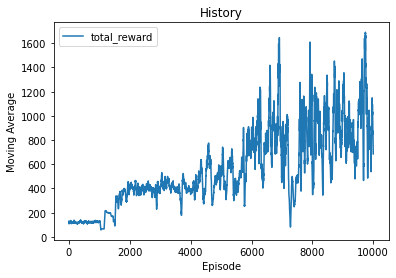

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(data, avg_span=30):
    fig1, ax1 = plt.subplots()
    for title, history in data:
        x = range(len(history))
        cumsum = np.cumsum(history)
        avgs = [cumsum[ep]/(ep+1) if ep<avg_span else (cumsum[ep]-cumsum[ep-avg_span])/avg_span for ep in x]
        ax1.plot(x, avgs, label=title)
    ax1.set_title("History")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Moving Average")
    ax1.legend()

plot([
    ('total_reward', history),
])